# Classification of images using PyTorch

## Reduction of dataset

In [1]:
import copy
from datetime import datetime
from pathlib import Path

import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassF1Score
from torchvision import datasets, transforms
from tqdm import tqdm
import yaml

# Custom imports
from source.dataset_reduction import load_dataset_from_yaml, check_images_size_equal_dataset, inspect_dataset
from source.cnn_model import train_model, create_objective, FlexibleCNN
from source.plotting_cnn import (
    plot_training_history,
    plot_random_predictions,
    plot_filter_weights,
    plot_feature_maps,
    plot_image,
)


# TO DO


hyperparameter
- used optuna, needs to be explained
- ELU activation function? see lecture notes
- cross validation and bootstrap


comment code
- done for plotting and this jupyter


Test vs pre-built model
- use pre-built model as paper to read?

architechture
- how to choose? add pooling and type to model generator


search "ML nodes UiO"
- apply for access
- 


data augmentation? already augmented?

In [2]:
# Print number of images for each class
yaml_path = Path.cwd().parent / "datasets" / "agropest12" / "data.yaml"
counts = inspect_dataset(yaml_path)



Number of images in train dataset
ants: 1038
bees: 1089
beetles: 854
caterpillars: 915
earthworms: 717
earwigs: 942
grasshoppers: 1044
moths: 1056
slugs: 809
snails: 1073
wasps: 1005
weevils: 960


In [3]:
# Settings for saving figures, models, etc

SAVE_FIGURES = True
SHOW_PLOT = True

SAVE_MODELS = True

# Optuna used for hyperparameter search
USE_OPTUNA = True
OPTUNA_N_TRIALS = 100


# Extract subset of data for testing when coding:
TESTING = True
number_images = 300 # Set to None to get all images    
number_train_images = None if number_images is None else int(number_images * 0.7)
number_test_images = None if number_images is None else int(number_images * 0.15)
number_validation_images = None if number_images is None else int(number_images * 0.15)
number_classes = 2


# Paths
current_dir = Path.cwd()
parent_dir = current_dir.parent
# Directory for saving figures
figures_path = parent_dir / "figures"
figures_path.mkdir(parents=True, exist_ok=True)
# Directory for saving models and summaries
models_path = parent_dir / "models"
models_path.mkdir(parents=True, exist_ok=True)


# Current timestamp for files
timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")



In [4]:
# Prepare dataset
"""
yaml_path = Path.cwd().parent / "datasets" / "agropest12" / "data.yaml"

with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)


# Training transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),        #256,256 for ImageNet
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalize (mean/std for ImageNet if using pretrained models).
])

# Validation/Test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),     
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize (mean/std for ImageNet if using pretrained models).
])

if TESTING:
    train_dataset = load_dataset_from_yaml(yaml_path, split="train", n_classes=number_classes, n_images_per_class=number_images, transform=train_transform)
    val_dataset = load_dataset_from_yaml(yaml_path, split="valid", n_classes=number_classes, n_images_per_class=number_test_images, transform=val_transform)
    test_dataset = load_dataset_from_yaml(yaml_path, split="test", n_classes=number_classes, n_images_per_class=number_validation_images, transform=val_transform)
else:
    train_dataset = load_dataset_from_yaml(yaml_path, split="train", transform=train_transform)
    val_dataset = load_dataset_from_yaml(yaml_path, split="valid", transform=val_transform)
    test_dataset = load_dataset_from_yaml(yaml_path, split="test", transform=val_transform)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
"""

'\nyaml_path = Path.cwd().parent / "datasets" / "agropest12" / "data.yaml"\n\nwith open(yaml_path, \'r\') as f:\n    config = yaml.safe_load(f)\n\n\n# Training transforms\ntrain_transform = transforms.Compose([\n    transforms.Resize((128, 128)),        #256,256 for ImageNet\n    #transforms.RandomHorizontalFlip(p=0.5),\n    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),\n    transforms.ToTensor(),\n    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # Normalize (mean/std for ImageNet if using pretrained models).\n])\n\n# Validation/Test transforms (no augmentation)\nval_transform = transforms.Compose([\n    transforms.Resize((128, 128)),     \n    transforms.ToTensor(),\n    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize (mean/std for ImageNet if using pretrained models).\n])\n\nif TESTING:\n    train_dataset = load_dataset_from_yaml(yaml_path, split="train", n_classes=number_c

In [5]:
from source.dataset_reduction import load_split_dataset
import random
random.seed(0)

# Example usage
yaml_path = Path.cwd().parent / "datasets" / "agropest12" / "data.yaml"
base_dir = yaml_path.parent

# Load config and select classes globally
with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)
all_classes = list(range(len(config['names'])))
selected_classes = None if number_classes is None else random.sample(all_classes, number_classes)

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
test_transform = val_transform

# Load splits
train_dataset = load_split_dataset(base_dir, "train", selected_classes=selected_classes,
                                n_images_per_class=number_train_images, transform=train_transform)
val_dataset = load_split_dataset(base_dir, "valid", selected_classes=selected_classes,
                                n_images_per_class=number_validation_images, transform=val_transform)
test_dataset = load_split_dataset(base_dir, "test", selected_classes=selected_classes,
                                n_images_per_class=number_test_images, transform=test_transform)


print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 420, Val size: 90, Test size: 83


In [6]:
# Dataloader  to start Optuna and quality control of dataloader

workers = 2
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=workers)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=workers)

In [7]:
# Check that images have equal size
check_images_size_equal_dataset(test_loader.dataset)


All images have the same size: (3, 128, 128)


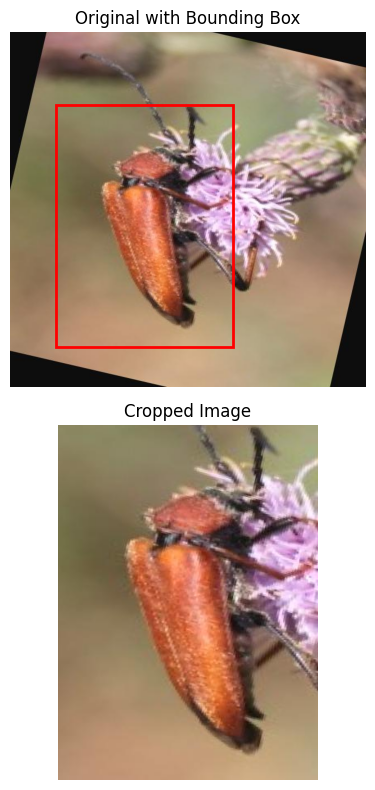

Label: 2


In [8]:
from source.dataset_reduction import YOLOClassificationDataset

dataset = YOLOClassificationDataset(
    images_dir = Path.cwd().parent / "datasets" / "agropest12" / "train" / "images",
    labels_dir = Path.cwd().parent / "datasets" / "agropest12" / "train" / "labels",
    transform=train_transform,
    visualize=True  # Enable visualization
)

# Trigger visualization for first sample
import random
random_idx = random.randint(0, len(dataset) - 1)
img, label = dataset[random_idx]
print(f"Label: {label}")


## Prepare PyTorch model

In [9]:
"""
# Quality control of DataLoader
dataloader_verbose = True
if dataloader_verbose:
    images, labels = next(iter(train_loader))
    print(f"Batch shape: {images.shape}")  # [32, 3, 224, 224]
    print(f"Pixel range: [{images.min().item():.4f}, {images.max().item():.4f}]")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels}")
"""

# Only a batch 
def qc_load_images(loader_dataset, selected_classes_names, label_map):

    images, labels = next(iter(loader_dataset))  # images: [B, C, H, W], labels: [B]

    print(f"Batch shape: {images.shape}")
    # Safely compute pixel range on CPU
    imgs_cpu = images.detach().cpu()
    print(f"Pixel range: [{images.min().item():.4f}, {images.max().item():.4f}]")
    print(f"Labels shape: {labels.shape}")

    unique_in_batch = torch.unique(labels)
    print(f"Original classes in batch: {unique_in_batch.tolist()}")
    print(f"Original labels: {labels.tolist()}")


    remapped = []
    for lab in labels.tolist():
        if lab in label_map:
            remapped.append(label_map[lab])
        else:
            remapped.append(None)

    print(f"Remapped indices: {remapped}")

    # Map remapped indices -> class names
    mapped_names = []
    for idx in remapped:
        if idx is None:
            mapped_names.append(None)
        elif 0 <= idx < len(selected_classes_names):
            mapped_names.append(selected_classes_names[idx])
        else:
            mapped_names.append(f"<idx {idx} out of range>")
    print("Mapped names:", mapped_names)
    print("-" * 50)




train_labels = [int(y) for _, y in train_dataset]
val_labels   = [int(y) for _, y in val_dataset]

# Build label_map from the union (sorted for deterministic index)
unique_labels = sorted(set(train_labels) | set(val_labels))
label_map = {old_label: new_idx for new_idx, old_label in enumerate(unique_labels)}
print("label_map:", label_map)

# Load class names from YAML
with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)

sorted_selected_classes = sorted(selected_classes)
selected_classes_names = [config['names'][i] for i in sorted_selected_classes]


print('Train QC:')
qc_load_images(train_loader, selected_classes_names, label_map)

print('Test QC:')
qc_load_images(test_loader, selected_classes_names, label_map)

print('Validation QC:')
qc_load_images(val_loader, selected_classes_names, label_map)


label_map: {6: 0, 11: 1}
Train QC:
Batch shape: torch.Size([64, 3, 128, 128])
Pixel range: [0.0000, 1.0000]
Labels shape: torch.Size([64])
Original classes in batch: [6, 11]
Original labels: [11, 6, 6, 6, 11, 6, 6, 6, 6, 11, 6, 6, 11, 11, 6, 11, 6, 6, 6, 11, 11, 11, 11, 6, 11, 6, 6, 6, 6, 11, 6, 6, 6, 6, 6, 11, 11, 11, 11, 6, 11, 11, 11, 11, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 6, 6, 11, 6, 6, 11, 11, 11]
Remapped indices: [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]
Mapped names: ['Weevils', 'Grasshoppers', 'Grasshoppers', 'Grasshoppers', 'Weevils', 'Grasshoppers', 'Grasshoppers', 'Grasshoppers', 'Grasshoppers', 'Weevils', 'Grasshoppers', 'Grasshoppers', 'Weevils', 'Weevils', 'Grasshoppers', 'Weevils', 'Grasshoppers', 'Grasshoppers', 'Grasshoppers', 'Weevils', 'Weevils', 'Weevils', 'Weevils', 'Grasshoppers', 'Weevils', 'Grasshoppers',

In [10]:
# Input image size for CNN model
images, labels = next(iter(val_loader))
input_size_img = tuple(images.shape[1:])  # (channels, height, width)
#num_classes = torch.unique(labels).numel()

#print(f'Images channel and size: {input_size_img}\nNumber of classes: {num_classes}')

In [ ]:
if USE_OPTUNA:
    
    objective = create_objective(input_size_img, train_dataset, val_dataset, 'cpu')

    db_path = models_path / f"{timestamp}_optuna_study.db"
    optuna_path = f"sqlite:///{db_path}"  # Convert to string for Optuna


    #pruner = optuna.pruners.SuccessiveHalvingPruner(
    #    min_resource=1,       # Minimum number of epochs before pruning
    #    reduction_factor=3,   # How aggressively to cut trials (keep 1/3 each round)
    #    min_early_stopping_rate=0  # Start pruning immediately after min_resource
    #)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=1, n_min_trials=5)

    study = optuna.create_study(direction='maximize',
                                pruner=pruner,
                                storage=optuna_path,
                                load_if_exists=False)

    study.optimize(objective, n_trials=OPTUNA_N_TRIALS)

    print("Best hyperparameters:", study.best_params)




[INFO] Original labels: [6, 11]
[INFO] Remapping: {6: 0, 11: 1}
[INFO] num_classes = 2


[I 2025-11-22 10:01:26,949] A new study created in RDB with name: no-name-60cf2dcf-2e71-4dff-84dc-700609f55229
[I 2025-11-22 10:06:24,660] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 0.0001, 'dropout_fc': 0.5, 'dropout_conv': 0.0, 'activation': 'ELU', 'batch_size': 16, 'use_batchnorm': False, 'n_conv_layers': 3, 'conv1_filters': 64, 'conv2_filters': 16, 'conv3_filters': 64, 'n_fc_layers': 2, 'fc1_neurons': 32, 'fc2_neurons': 64}. Best is trial 0 with value: 0.5.
[I 2025-11-22 10:07:31,036] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 0.01, 'dropout_fc': 0.5, 'dropout_conv': 0.0, 'activation': 'LeakyReLU', 'batch_size': 32, 'use_batchnorm': False, 'n_conv_layers': 1, 'conv1_filters': 128, 'n_fc_layers': 2, 'fc1_neurons': 32, 'fc2_neurons': 16}. Best is trial 0 with value: 0.5.
[I 2025-11-22 10:11:04,352] Trial 2 finished with value: 0.4777777777777778 and parameters: {'learning_rate': 0.0001, 'dropout_fc': 0.1, 'dropout_conv': 0.3, 'activatio

In [ ]:
# Visualize and save Optuna figures
if USE_OPTUNA:
    from optuna.visualization import plot_optimization_history, plot_param_importances

    # Generate plots
    fig_history = plot_optimization_history(study)
    fig_importance = plot_param_importances(study)

    # Show in notebook
    if SHOW_PLOT:
        fig_history.show()
        fig_importance.show()

    if SAVE_FIGURES:
        path_history = Path(figures_path / f'{timestamp}_optuna_history_number_images{number_images}.png')
        path_importance = Path(figures_path / f'{timestamp}_optuna_importance_number_images{number_images}.png')

        # Save as PNG
        fig_history.write_image(path_history)
        fig_importance.write_image(path_importance)

In [ ]:
# Define model with Optuna or manual settings


if USE_OPTUNA:
    best_params = study.best_params

    # Build conv_layers dynamically
    n_conv_layers = best_params['n_conv_layers']
    conv_layers = [(best_params[f'conv{i+1}_filters'], 3) for i in range(n_conv_layers)]

    # Build fc_layers dynamically
    n_fc_layers = best_params['n_fc_layers']
    fc_layers = [best_params[f'fc{i+1}_neurons'] for i in range(n_fc_layers)]

    # Map activation name to class
    activation_map = {
        'ReLU': nn.ReLU,
        'LeakyReLU': nn.LeakyReLU,
        'ELU': nn.ELU,
        'sigmoid': nn.Sigmoid
        }
    activation_choice = activation_map[best_params['activation']]

    model_flexible = FlexibleCNN(
        input_size=input_size_img,
        num_classes=number_classes,
        conv_layers=conv_layers,
        fc_layers=fc_layers,
        activation=activation_choice,
        dropout_fc=best_params['dropout_fc'],
        dropout_conv=best_params['dropout_conv'],
        use_batchnorm=best_params.get('use_batchnorm', True),  
        pool_type=best_params.get('pool_type', "avg"),         
        global_pool=best_params.get('global_pool', "max")      
    )

else:  # Manual settings
    model_flexible = FlexibleCNN(
        input_size=input_size_img,
        num_classes=number_classes,
        conv_layers=[(32, 3)], #(64, 3), (128, 3)],
        fc_layers=[32, 16],   #[256, 128]
        activation=nn.ReLU,
        dropout_fc=0.3,
        dropout_conv=0.1,
        use_batchnorm=True,
        pool_type="avg",
        global_pool="max"
    )


In [ ]:
# Model summary

from torchinfo import summary
model_summary = summary(model_flexible, input_size=images.shape, col_names=["input_size", "output_size", "num_params"])
model_summary


# Alternative model summary
#from torchsummary import summary
#summary(model_flexible, input_size=input_size_img)

In [ ]:
# Set batch size dataloader with Optuna result
if USE_OPTUNA:
    batch_size = best_params['batch_size']
else: # during testing few images are chosen sometimes
    if len(train_dataset) < 20:
        batch_size = 16
    elif len(train_dataset) > 20 and len(train_dataset) < 100:
        batch_size = 32
    else:
        batch_size = 64 


In [ ]:
if TESTING:
    from source.cnn_model import RemappedSubset

    def prepare_subset_with_remapping(train_subset, val_subset, test_subset):
        # Collect all labels from train, val, and test
        all_labels = [y for _, y in train_subset] + [y for _, y in val_subset] + [y for _, y in test_subset]

        unique_labels = sorted(set(all_labels))
        label_map = {old_label: new_idx for new_idx, old_label in enumerate(unique_labels)}
        num_classes = len(unique_labels)

        print(f"[INFO] Original labels: {unique_labels}")
        print(f"[INFO] Remapping: {label_map}")
        print(f"[INFO] num_classes = {num_classes}")

        return (
            RemappedSubset(train_subset, label_map),
            RemappedSubset(val_subset, label_map),
            RemappedSubset(test_subset, label_map),
            num_classes
        )

    train_dataset, val_dataset, test_dataset, num_classes = prepare_subset_with_remapping(
        train_dataset, val_dataset, test_dataset
    )


In [ ]:
# Dataloader with batch size from Optuna or manual
workers = 2
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=workers)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=workers)

In [ ]:
# Parameters for training

# training based on Optuna or not
learning_rate = best_params['learning_rate'] if USE_OPTUNA else 0.001

optimizer = torch.optim.Adam(model_flexible.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
epochs = 30

# Train with early stopping + scheduler
history = train_model(
    model=model_flexible,
    num_epochs=epochs,
    train_dl=train_loader,
    valid_dl=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device='cpu',
    verbose=True,
    patience_val=5
)

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import (
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassConfusionMatrix
)

def evaluate_classification(model, dataloader, num_classes, device='cpu', class_names=None):
    """
    Evaluate a classification model on a given dataloader.
    Computes Accuracy, Macro F1, Per-class Precision & Recall, and Confusion Matrix.
    Optionally plots confusion matrix with class names.
    """
    model.eval()
    model.to(device)

    # Initialize metrics
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
    precision_metric = MulticlassPrecision(num_classes=num_classes, average=None).to(device)
    recall_metric = MulticlassRecall(num_classes=num_classes, average=None).to(device)
    confmat_metric = MulticlassConfusionMatrix(num_classes=num_classes).to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            pred_classes = preds.argmax(dim=1)

            correct += (pred_classes == y_batch).sum().item()
            total += y_batch.size(0)

            print(pred_classes.min(), pred_classes.max())
            print(y_batch.min(), y_batch.max())
            assert pred_classes.max().item() < num_classes, "Predicted class index out of range"
            assert y_batch.max().item() < num_classes, "True label index out of range"


            # Update metrics
            f1_metric.update(pred_classes, y_batch)
            precision_metric.update(pred_classes, y_batch)
            recall_metric.update(pred_classes, y_batch)
            confmat_metric.update(pred_classes, y_batch)
    



    # Compute metrics
    accuracy = correct / total
    macro_f1 = f1_metric.compute().item()
    precision_per_class = precision_metric.compute().cpu().numpy()
    recall_per_class = recall_metric.compute().cpu().numpy()
    confmat = confmat_metric.compute().cpu().numpy()

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print("Precision per class:", precision_per_class)
    print("Recall per class:", recall_per_class)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confmat, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return {
        "accuracy": accuracy,
        "macro_f1": macro_f1,
        "precision_per_class": precision_per_class,
        "recall_per_class": recall_per_class,
        "confusion_matrix": confmat
    }

results = evaluate_classification(
    model=model_flexible,
    dataloader=test_loader,
    num_classes=num_classes,
    device='cpu'#,
    #class_names=["Class 0", "Class 1"]  # Optional
)

In [ ]:
# Evaluate test dataset

model_flexible.eval()
device = 'cpu'

# Initialize metric
f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

correct = 0
total = 0

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        preds = model_flexible(x_batch)
        pred_classes = preds.argmax(dim=1)

        correct += (pred_classes == y_batch).sum().item()
        total += y_batch.size(0)

        # Update metric state
        f1_metric.update(pred_classes, y_batch)

# Compute F1 after all batches
test_accuracy = correct / total
avg_f1_score = f1_metric.compute().item()

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Average F1-score: {avg_f1_score:.4f}")


In [ ]:
# Write model and summary to file
if SAVE_MODELS:
    path_summary = Path(models_path / f'{timestamp}_model_summary_number_images{number_images}_test_accuracy{test_accuracy:.4f}_avgf1_{avg_f1_score:.4f}.txt')
    with open(path_summary, "w", encoding="utf-8") as f:
        f.write(str(model_summary))
    
    path_model = Path(models_path / f'{timestamp}_model_summary_number_images{number_images}_test_accuracy{test_accuracy:.4f}_avgf1_{avg_f1_score:.4f}_weights.pth')
    torch.save(model_flexible.state_dict(), path_model)

In [ ]:
# Plot training and validation loss and accuracy

plot_training_history(history, number_images, path=figures_path, save_figures=SAVE_FIGURES, show_plot=SHOW_PLOT)

In [ ]:
# Plot predictions and true labels





with open(yaml_path, 'r') as f:
    config = yaml.safe_load(f)
sorted_seleted_classes = sorted(selected_classes)
print(sorted_seleted_classes)
selected_classes_names = [config['names'][i] for i in sorted_seleted_classes]
print(selected_classes_names)

n_samples = 12
if len(test_dataset) > n_samples:
    # Auto layout (2x6 for 12 samples)
    plot_random_predictions(
        model_flexible,
        test_dataset,
        num_samples=n_samples,
        path=figures_path,
        time=timestamp,
        number_images=number_images,
        rows=2, cols=6,
        class_names=config['names'],           # Full list from YAML
        selected_classes=selected_classes_names,  # Names only
        device="cpu",
        save_figures=SAVE_FIGURES,
        show_plot=SHOW_PLOT
    )

n_samples = 4
if len(test_dataset) > n_samples:
    # Custom layout (2x2 for 4 samples)

    plot_random_predictions(
        model_flexible,
        test_dataset,
        num_samples=n_samples,
        path=figures_path,
        time=timestamp,
        number_images=number_images,
        rows=2, cols=2,
        class_names=config['names'],           # Full list from YAML
        selected_classes=selected_classes_names,  # Names only
        device="cpu",
        save_figures=SAVE_FIGURES,
        show_plot=SHOW_PLOT
    )


In [ ]:
# Plot filter weights (first convolutional layer)

plot_filter_weights(model_flexible, figures_path, timestamp, number_images, rows=2, cols=2, channel=0, save_figures=SAVE_FIGURES, show_plot=SHOW_PLOT) # channel as in RGB


In [ ]:
# Plot feature maps for a sample image

# Random sample from test dataset
random_index = np.random.randint(0, len(test_dataset))
sample_img, _ = test_dataset[random_index]

# Plot sample image
plot_image(sample_img, figures_path, timestamp, number_images, title='Image sample from test dataset', save_figures=SAVE_FIGURES, show_plot=SHOW_PLOT)

# Plot all Conv2D
for i, layer in enumerate(model_flexible.features):
    if isinstance(layer, nn.Conv2d):
        plot_feature_maps(model_flexible, i,  sample_img, figures_path, timestamp, number_images, layers_to_show=[0,3], num_maps=4, rows=2, cols=2, cmap='gray', save_figures=SAVE_FIGURES, show_plot=SHOW_PLOT)

